Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Descent Env"

In [1]:
import numpy as np
from descent_env import DescentEnv
import random 

pygame 2.5.2 (SDL 2.28.3, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using Python-based geo functions


In [2]:
# Cambiar render_mode a rgb_array para entrenar/testear
env = DescentEnv(render_mode='rgb_array')

Reading config from C:\Users\fbrio\bluesky\settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: C:\Users\fbrio\bluesky\cache\navdata.p
Successfully loaded OpenAP performance model
Failed to load BADA performance model
Successfully loaded legacy performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


Observation Space

In [3]:
env.observation_space

Dict('altitude': Box(-inf, inf, (1,), float64), 'runway_distance': Box(-inf, inf, (1,), float64), 'target_altitude': Box(-inf, inf, (1,), float64), 'vz': Box(-inf, inf, (1,), float64))

Action Space

In [4]:
env.action_space

Box(-1.0, 1.0, (1,), float64)

# Discretizacion

In [20]:
altitude_space = np.linspace(-30000, 30000, 50)
vertical_velocity_space = np.linspace(-30000, 30000, 50)
target_altitude_space = np.linspace(-30000, 30000, 50)
runway_distance_space = np.linspace(-30000, 30000, 50)
altitude_space

array([-30000.        , -28775.51020408, -27551.02040816, -26326.53061224,
       -25102.04081633, -23877.55102041, -22653.06122449, -21428.57142857,
       -20204.08163265, -18979.59183673, -17755.10204082, -16530.6122449 ,
       -15306.12244898, -14081.63265306, -12857.14285714, -11632.65306122,
       -10408.16326531,  -9183.67346939,  -7959.18367347,  -6734.69387755,
        -5510.20408163,  -4285.71428571,  -3061.2244898 ,  -1836.73469388,
         -612.24489796,    612.24489796,   1836.73469388,   3061.2244898 ,
         4285.71428571,   5510.20408163,   6734.69387755,   7959.18367347,
         9183.67346939,  10408.16326531,  11632.65306122,  12857.14285714,
        14081.63265306,  15306.12244898,  16530.6122449 ,  17755.10204082,
        18979.59183673,  20204.08163265,  21428.57142857,  22653.06122449,
        23877.55102041,  25102.04081633,  26326.53061224,  27551.02040816,
        28775.51020408,  30000.        ])

Obtener el estado a partir de la observación

In [21]:
def get_state(obs):
    alt = obs['altitude'][0]
    vz = obs['vz'][0]
    target_alt = obs['target_altitude'][0]
    runway_dist = obs['runway_distance'][0]
    alt_idx = min(np.digitize(alt, altitude_space), len(altitude_space)-1)
    vz_idx = min(np.digitize(vz, vertical_velocity_space), len(vertical_velocity_space)-1)
    target_alt_idx = min(np.digitize(target_alt, target_altitude_space), len(target_altitude_space)-1)
    runway_dist_idx = min(np.digitize(runway_dist, runway_distance_space), len(runway_distance_space)-1)
    return alt_idx, vz_idx, target_alt_idx, runway_dist_idx

In [22]:
obs = env.observation_space.sample()
print(obs)
state = get_state(obs) # Ejemplo de obs
state

OrderedDict([('altitude', array([-1.6235862])), ('runway_distance', array([1.66338287])), ('target_altitude', array([-0.28399727])), ('vz', array([-1.03146019]))])


(25, 25, 25, 25)

Discretización de las acciones

In [23]:
actions = list(np.linspace(-1, 1, 10))
actions

[-1.0,
 -0.7777777777777778,
 -0.5555555555555556,
 -0.33333333333333337,
 -0.11111111111111116,
 0.11111111111111116,
 0.33333333333333326,
 0.5555555555555554,
 0.7777777777777777,
 1.0]

In [24]:
def get_sample_action():
    return random.choice(actions)

Inicilización de la tabla Q

In [25]:
Q = np.zeros((len(altitude_space), len(vertical_velocity_space), len(target_altitude_space), len(runway_distance_space), len(actions)))
Q

array([[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0.

In [26]:
# Tamaños de cada dimensión del estado
n_alt = len(altitude_space)
n_vz = len(vertical_velocity_space)
n_target_alt = len(target_altitude_space)
n_rwy_dist = len(runway_distance_space)
n_actions = len(actions)

# Inicializamos Q-table con ceros
Q = np.zeros((n_alt, n_vz, n_target_alt, n_rwy_dist, n_actions))


In [27]:
def choose_action(state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)  # acción aleatoria
    else:
        return np.argmax(Q[state])  # mejor acción según Q


# Hiperparámetros y definiciones

In [36]:
# Hiperparámetros
alphas = [0.7,0.8,0.9]  # Tasa de aprendizaje
gammas = [0.5,0.6,0.7] # Factor de descuento
episodes = 5000 # Episodios de entrenamiento
test_episodes = 100  # Episodios de testeo

epsilon = 1  # Valor inicial de epsilon
epsilon_decay = 0.999  # Decaimiento de epsilon
epsilon_min = 0.01  # Valor mínimo de epsilon



# Training

In [29]:
def train(alpha, gamma, epsilon, epsilon_min, epsilon_decay, episodes):
    Q = np.zeros((n_alt, n_vz, n_target_alt, n_rwy_dist, n_actions))
    rewards_per_episode = []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0

        while not done:
            action_idx = choose_action(state, epsilon)
            action = np.array([actions[action_idx]])

            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = get_state(next_obs)
            done = terminated or truncated

            best_next = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state + (best_next,)]
            td_error = td_target - Q[state + (action_idx,)]
            Q[state + (action_idx,)] += alpha * td_error

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return Q, np.mean(rewards_per_episode)


# Test

In [30]:
def test_agent(Q):
    rewards = []

    for _ in range(test_episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0

        while not done:
            action_idx = np.argmax(Q[state])  # greedy
            action = np.array([actions[action_idx]])
            next_obs, reward, terminated, _, _ = env.step(action)
            state = get_state(next_obs)
            done = terminated
            total_reward += reward

        rewards.append(total_reward)

    return np.mean(rewards)

# Inicio

In [31]:
results = []

In [18]:
# Entrenamiento y testing por cada epsilon
print(f"\n=== Entrenando con epsilon: {epsilon:.2f} ===")
print(f"\n--- Entrenando con {episodes} episodios ---")
for alpha in alphas:
    for gamma in gammas:
        print(f"\n--- Entrenando con alpha: {alpha:.2f}, gamma: {gamma:.2f} ---")
        Q, train_avg_reward = train(alpha, gamma, epsilon, epsilon_min, epsilon_decay, episodes)
        print(f"--- Entrenamiento finalizado con epsilon {epsilon:.2f} ---")    
        print(f"--- Evaluando desempeño (testeo sin exploración) ---")
        test_avg_reward = test_agent(Q)
        results.append({
        "alpha": alpha,
        "gamma": gamma,
        "episodes": episodes, 
        "train_avg_reward": train_avg_reward,
        "test_avg_reward": test_avg_reward
        })
        with open("resultados_qlearning.txt", "w") as f:
            for res in results:
                f.write(str(res) + "\n")
                print(f"Resultados: {res}")


=== Entrenando con epsilon: 1.00 ===

--- Entrenando con 5000 episodios ---

--- Entrenando con alpha: 0.60, gamma: 0.20 ---


NameError: name 'train' is not defined

In [ ]:
results

{'alpha': 0.23,
 'gamma': 0.9,
 'episodes': 5000,
 'train_avg_reward': -235.2505073810607,
 'test_avg_reward': -126.96692063013333}

In [32]:
# Mostrar resultados
print("\n=== Comparación Final ===")
for res in results:
   print(res)


=== Comparación Final ===


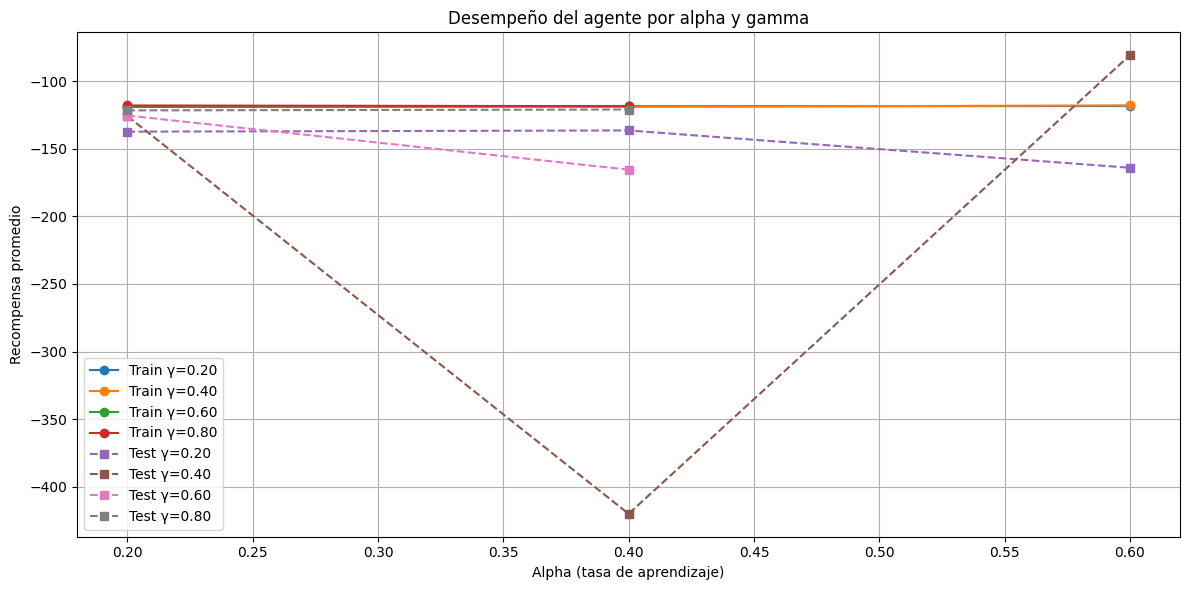

In [26]:
import matplotlib.pyplot as plt

# Organizar resultados por gamma
from collections import defaultdict

# Diccionarios para almacenar listas de recompensas por gamma
train_by_gamma = defaultdict(list)
test_by_gamma = defaultdict(list)

# Llenamos los diccionarios
for res in results:
    gamma = res["gamma"]
    train_by_gamma[gamma].append((res["alpha"], res["train_avg_reward"]))
    test_by_gamma[gamma].append((res["alpha"], res["test_avg_reward"]))

# Crear gráfico
plt.figure(figsize=(12, 6))

# Entrenamiento
for gamma in sorted(train_by_gamma.keys()):
    sorted_data = sorted(train_by_gamma[gamma], key=lambda x: x[0])  # ordenar por alpha
    alphas_sorted, rewards = zip(*sorted_data)
    plt.plot(alphas_sorted, rewards, marker='o', label=f'Train γ={gamma:.2f}')

# Testeo
for gamma in sorted(test_by_gamma.keys()):
    sorted_data = sorted(test_by_gamma[gamma], key=lambda x: x[0])  # ordenar por alpha
    alphas_sorted, rewards = zip(*sorted_data)
    plt.plot(alphas_sorted, rewards, marker='s', linestyle='--', label=f'Test γ={gamma:.2f}')

# Etiquetas y formato
plt.xlabel('Alpha (tasa de aprendizaje)')
plt.ylabel('Recompensa promedio')
plt.title('Desempeño del agente por alpha y gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
def train_stochastic(alpha, gamma, epsilon, epsilon_min, epsilon_decay, episodes):
    Q = np.zeros((n_alt, n_vz, n_target_alt, n_rwy_dist, n_actions))
    rewards_per_episode = []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = get_state(obs)
        done = False
        total_reward = 0

        while not done:
            action_idx = choose_action(state, epsilon)
            action = np.array([actions[action_idx]])

            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = get_state(next_obs)
            done = terminated or truncated

            # Stochastic Q-learning: sample next action for update
            next_action_idx = np.random.randint(n_actions)
            td_target = reward + gamma * Q[next_state + (next_action_idx,)]
            td_error = td_target - Q[state + (action_idx,)]
            Q[state + (action_idx,)] += alpha * td_error

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return Q, np.mean(rewards_per_episode)

In [40]:
results = [
    {'alpha': 0.7, 'gamma': 0.5, 'episodes': 5000, 'train_avg_reward': -125.67776288435766, 'test_avg_reward': -125.14546692599998, 'stochastic': True},
    {'alpha': 0.7, 'gamma': 0.6, 'episodes': 5000, 'train_avg_reward': -125.59232916651933, 'test_avg_reward': -250.8641859828, 'stochastic': True},
    {'alpha': 0.7, 'gamma': 0.7, 'episodes': 5000, 'train_avg_reward': -125.57839614049101, 'test_avg_reward': -79.72563557216668, 'stochastic': True},
    {'alpha': 0.8, 'gamma': 0.5, 'episodes': 5000, 'train_avg_reward': -125.14129169011733, 'test_avg_reward': -128.42927534706666, 'stochastic': True},
    {'alpha': 0.8, 'gamma': 0.6, 'episodes': 5000, 'train_avg_reward': -125.73452672263167, 'test_avg_reward': -79.71799111783332, 'stochastic': True},
    {'alpha': 0.8, 'gamma': 0.7, 'episodes': 5000, 'train_avg_reward': -125.48999245606265, 'test_avg_reward': -79.93045225200001, 'stochastic': True},
    {'alpha': 0.9, 'gamma': 0.5, 'episodes': 5000, 'train_avg_reward': -125.78453329165934, 'test_avg_reward': -161.5915210868, 'stochastic': True},
    {'alpha': 0.9, 'gamma': 0.6, 'episodes': 5000, 'train_avg_reward': -125.58725493989434, 'test_avg_reward': -452.9643976, 'stochastic': True},
    {'alpha': 0.9, 'gamma': 0.7, 'episodes': 5000, 'train_avg_reward': -125.21662699160902, 'test_avg_reward': -124.70271689400002, 'stochastic': True}
]

In [41]:
# Entrenamiento y testing usando Q-learning estocástico
print(f"\n=== Entrenando (Stochastic Q-learning) con epsilon: {epsilon:.2f} ===")
print(f"\n--- Entrenando con {episodes} episodios ---")
for alpha in alphas:
    for gamma in gammas:
        print(f"\n--- Entrenando con alpha: {alpha:.2f}, gamma: {gamma:.2f} ---")
        Q_stoch, train_avg_reward_stoch = train_stochastic(alpha, gamma, epsilon, epsilon_min, epsilon_decay, episodes)
        print(f"--- Entrenamiento estocástico finalizado con epsilon {epsilon:.2f} ---")    
        print(f"--- Evaluando desempeño estocástico (testeo sin exploración) ---")
        test_avg_reward_stoch = test_agent(Q_stoch)
        results.append({
            "alpha": alpha,
            "gamma": gamma,
            "episodes": episodes, 
            "train_avg_reward": train_avg_reward_stoch,
            "test_avg_reward": test_avg_reward_stoch,
            "stochastic": True
        })
        with open("resultados_qlearning.txt", "w") as f:
            for res in results:
                f.write(str(res) + "\n")
                print(f"Resultados: {res}")


=== Entrenando (Stochastic Q-learning) con epsilon: 1.00 ===

--- Entrenando con 5000 episodios ---

--- Entrenando con alpha: 0.70, gamma: 0.50 ---


KeyboardInterrupt: 

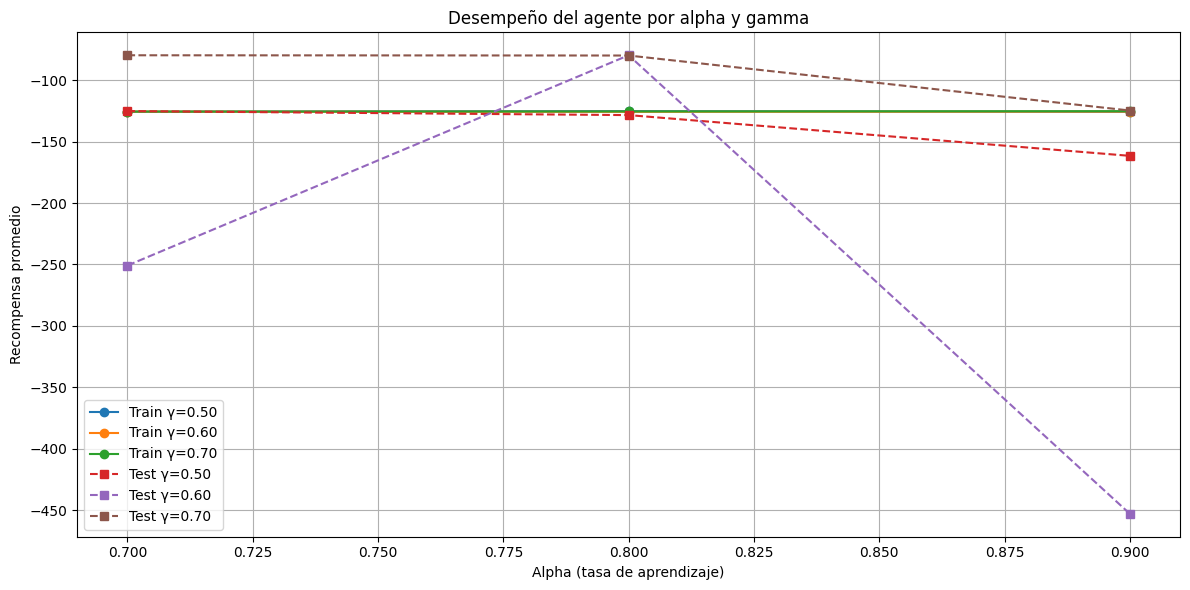

In [42]:
from collections import defaultdict

import matplotlib.pyplot as plt

# Organizar resultados por gamma

train_by_gamma = defaultdict(list)
test_by_gamma = defaultdict(list)

for res in results:
    gamma = res["gamma"]
    train_by_gamma[gamma].append((res["alpha"], res["train_avg_reward"]))
    test_by_gamma[gamma].append((res["alpha"], res["test_avg_reward"]))

plt.figure(figsize=(12, 6))

for gamma in sorted(train_by_gamma.keys()):
    sorted_data = sorted(train_by_gamma[gamma], key=lambda x: x[0])
    alphas_sorted, rewards = zip(*sorted_data)
    plt.plot(alphas_sorted, rewards, marker='o', label=f'Train γ={gamma:.2f}')

for gamma in sorted(test_by_gamma.keys()):
    sorted_data = sorted(test_by_gamma[gamma], key=lambda x: x[0])
    alphas_sorted, rewards = zip(*sorted_data)
    plt.plot(alphas_sorted, rewards, marker='s', linestyle='--', label=f'Test γ={gamma:.2f}')

plt.xlabel('Alpha (tasa de aprendizaje)')
plt.ylabel('Recompensa promedio')
plt.title('Desempeño del agente por alpha y gamma')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()